In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

In [3]:
tickers = tickers.Symbol.to_list()

In [4]:
#Wikipedia puts decimals in ticker names which are technically invalid
tickers = [i.replace('.','-') for i in tickers]

In [40]:
#Upmove = take daily return if return is positive, 0 is returned if daily return is negative or 0
#Downmove = gt absolute value of daily return if return is negative, return 0 if daily returns are positive or 0
#EWM - exponential moving average
#WilderSmoothingMethod(WSM) is the same as an exponential moving average but diff smoothing factor
# i.e., in WSM: a = 1/N - in exonential moving average: a = 2/(N+1)
# Therefore to attain a WSM alpha of 1/10 we need a span of 19 (2/19+1)
# Because there is no WSM in python we use the EWM with span 19

#RS = average upmove/average downmove 
#RSI = 100 - 100/(1+RS)

#On locator function, setting a buy column under conditions that RSI < 30 and Close > MA200
#These are the buy signals...


def RSIcalc(asset):
    df = yf.download(asset, start='2010-01-01', auto_adjust=False, timeout=30)
    df = df.xs(asset,axis=1,level="Ticker")
    df['MA200'] = df['Close'].rolling(window=200).mean()
    df['price change'] = df['Close'].pct_change()
    df['Upmove'] = df['price change'].apply(lambda x: x if x > 0 else 0) 
    df['Downmove'] = df['price change'].apply(lambda x: abs(x) if x < 0 else 0)
    df['avg Up'] = df['Upmove'].ewm(span=19).mean()
    df['avg Down'] = df['Downmove'].ewm(span=19).mean()
    df['RS'] = df['avg Up']/df['avg Down']
    df['RSI'] = df['RS'].apply(lambda x: 100-(100/(x+1)))
    df.loc[(df['Close'] > df['MA200']) & (df['RSI'] < 30), 'Buy'] = 'Yes'
    df.loc[(df['Close'] < df['MA200']) & (df['RSI'] > 30), 'Buy'] = 'No'
    df.dropna(inplace=True)

    return df

    

In [41]:
# RSI < 30 = "oversold" - RSI > 70 = "overbought"
# Hence we look for sub 30 to indicate its sustained high selling pressure

In [53]:
#iloc[i+1] because we want to buy on the next day after the signal
#EDITED (df)-11 because if we look 10 days ahead in the last 9 days well go over the df's last day therefore itll be invalid
def getSignals(df):
    Buying_dates = []
    Selling_dates = []

    for i  in range (len(df)-11):
        if 'Yes' in df['Buy'].iloc[i]:
            Buying_dates.append(df.iloc[i+1].name)
            for j in range(1, 11):
                if df['RSI'].iloc[i + j] > 40:
                    Selling_dates.append(df.iloc[i+j+1].name)
                    break
                elif j == 10:
                    Selling_dates.append(df.iloc[i+j+1].name)

    return Buying_dates, Selling_dates


In [54]:
frame = RSIcalc(tickers[0])
buy, sell = getSignals(frame)

[*********************100%***********************]  1 of 1 completed


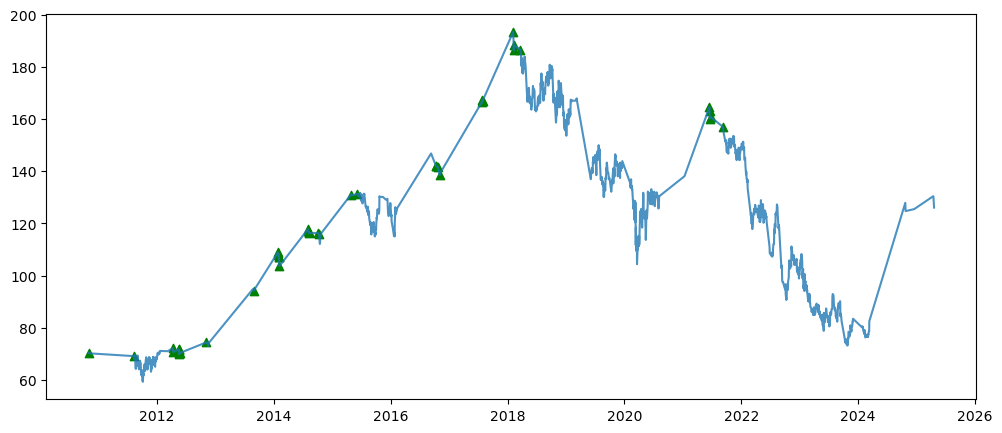

In [55]:
plt.figure(figsize=(12,5))
plt.scatter(frame.loc[buy].index,frame.loc[buy]['Close'], marker= '^', c='g')
plt.plot(frame['Close'], alpha=0.8)

In [56]:
profits = (frame.loc[sell].Open.values - frame.loc[buy].Open.values)/frame.loc[buy].Open.values

ValueError: operands could not be broadcast together with shapes (61,) (43,) 

In [57]:
wins = [i for i in profits if i > 0]

In [47]:
win_rate = len(wins)/len(profits)

In [48]:
win_rate

0.5116279069767442

In [49]:
len(profits)

43

In [50]:
#labelled as a matrix because we are storing profits and assets

matrixsignals = []
matrixprofits = []

for i in range(len(tickers)):
    frame = RSIcalc(tickers[i])
    buy, sell = getSignals(frame)
    profits = (frame.loc[sell].Open.values - frame.loc[buy].Open.values)/frame.loc[buy].Open.values
    matrixsignals.append(buy)
    matrixprofits.append(profits)





[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [51]:
allprofit = []

for i in matrixprofits:
    for e in i:
        allprofit.append(e)


In [52]:
wins = [i for i in allprofit if i > 0]
len(wins)/len(allprofit)

0.39329402446537004